In [1]:
from pathlib import Path
import pandas as pd 

path = Path("../Baseline") / "df_baseline.csv"
df_baseline = pd.read_csv(path)

In [2]:
df_baseline.head()

,Time,Date,Sender_account,Receiver_account,Amount,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type,year,month,weekday,hour,Payment_currency_iso,Received_currency_iso
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,2022,10,5,10,GBP,GBP
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK,UAE,Cross-border,0,Normal_Fan_Out,2022,10,5,10,GBP,AED
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK,UK,Cheque,0,Normal_Small_Fan_Out,2022,10,5,10,GBP,GBP
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK,UK,ACH,0,Normal_Fan_In,2022,10,5,10,GBP,GBP
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,2022,10,5,10,GBP,GBP


[LightGBM] [Info] Number of positive: 7898, number of negative: 23694
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,001109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 31592, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,250000 -> initscore=-1,098612
[LightGBM] [Info] Start training from score -1,098612

Метрики на undersampling-тесте:
accuracy: 0.8579
f1: 0.6584
precision: 0.8250
recall: 0.5478
roc_auc: 0.8824

Метрики на реальном тесте:
accuracy: 0.9460
f1: 0.0191
precision: 0.0097
recall: 0.5063
roc_auc: 0.8402

Матрица ошибок на реальном тесте:


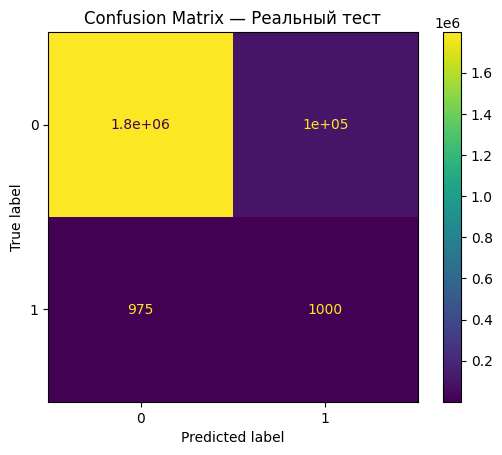


ROC-кривая не реальном тесте:


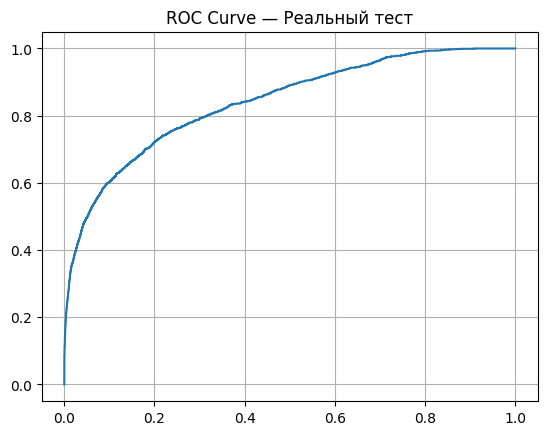

In [7]:
from LightGBM_model import LightGBMBaseline
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Инициализация и подготовка данных
baseline = LightGBMBaseline()
data = baseline.prepare_data(df_baseline)

# Обучение
baseline.train(data["X_train"], data["y_train"])

# Оценка
metrics_bal = baseline.evaluate(data["X_test_bal"], data["y_test_bal"])
metrics_real = baseline.evaluate(data["X_test_real"], data["y_test_real"])

# 5. Вывод метрик
print("\nМетрики на undersampling-тесте:")
for k, v in metrics_bal.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")

print("\nМетрики на реальном тесте:")
for k, v in metrics_real.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")

# 6. Визуализация confusion matrix и ROC для реального теста
print("\nМатрица ошибок на реальном тесте:")
ConfusionMatrixDisplay(metrics_real["confusion_matrix"]).plot()
plt.title("Confusion Matrix — Реальный тест")
plt.grid(False)
plt.show()

print("\nROC-кривая не реальном тесте:")
fpr, tpr, _ = metrics_real["roc_curve"]
plt.plot(fpr, tpr)
plt.title("ROC Curve — Реальный тест")
plt.grid()
plt.show()

c:\Users\ostro\Documents\my_first_data_project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:17:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


accuracy: 0.8432
f1: 0.6261
precision: 0.7751
recall: 0.5251
roc_auc: 0.8479


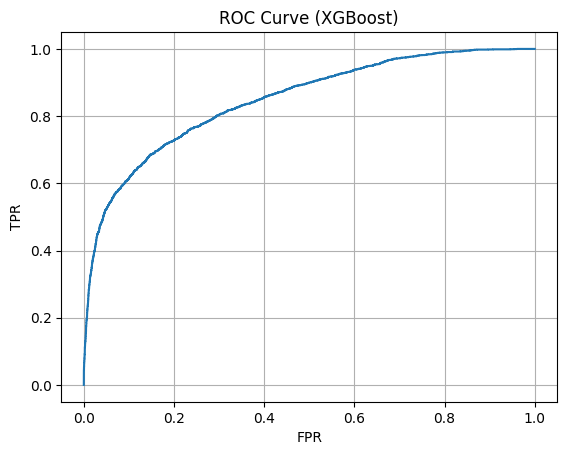

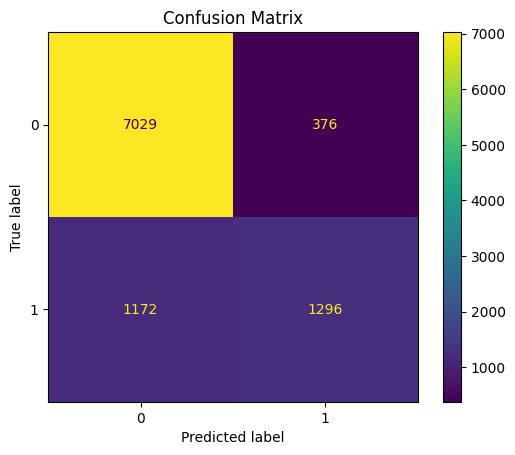

In [4]:
from XGBoost_model import XGBoostBaseline
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Загружаем данные
df = pd.read_csv("df_baseline.csv")

# Работа с моделью
baseline = XGBoostBaseline()
df_prep = baseline.preprocess(df)
df_bal = baseline.undersample(df_prep)

X = df_bal.drop(columns=["Is_laundering"])
y = df_bal["Is_laundering"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

baseline.train(X_train, y_train)
metrics = baseline.evaluate(X_test, y_test)

# Метрики
for k, v in metrics.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")

# ROC
fpr, tpr, _ = metrics["roc_curve"]
plt.plot(fpr, tpr)
plt.title("ROC Curve (XGBoost)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay(metrics["confusion_matrix"]).plot()
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# Сохраняем модель
baseline.save_model()